Fault-tolerant preparation of a 15-qubit quantum Reed-Muller code
=================================================================

Our goal is to prepare a QRM code in logical state $\ket{\overline{+}}$,
and perform a destructive measurement on $X$ basis,
and to leverage post-selection to have an effective distance 3,
that is, to have a cubic logical error rate.
Schematically, this can be done by preparing all data qubits in $\ket{+}$ and then measuring 10 $Z$-checks.
However, a Shor type stabilizer measurement can spread errors from the ancilla and lead to correlated data qubit errors.
In this note, we tackle this problem by several means, including flag gadgets and Steane type measurements.
We want to optimize the scheme to reduce the overhead and logical error rate.

The QRM code is labelled by the convention of an RM code.
Qubits are labelled by 4-bit binaries with 0000 excluded.
0001|0010|0011|0100|0101|0110|0111|1000|1001|1010|1011|1100|1101|1110|1111
----|----|----|----|----|----|----|----|----|----|----|----|----|----|----
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|

Put on tetrahedron:
- vertices: qubits with one '1' (1, 2, 4, 8)
- edges: qubits with 2 '1's, or adding 2 vertices (3, 5, 6, 9, 10, 12)
- faces: qubits with 3 '1's, or adding 3 vertices (7, 11, 13, 14)
- body: qubits with 4 '1's, or adding 4 vertices (15)

Four $X$-checks and 10 $Z$-checks are then

In [ ]:
QRM_X_CHECKS = [
[1,3,5,7,9,11,13,15],
[2,3,6,7,10,11,14,15],
[4,5,6,7,12,13,14,15],
[8,9,10,11,12,13,14,15]
]
QRM_Z_CHECKS = QRM_X_CHECKS + [
[3,7,11,15],
[5,7,13,15],
[6,7,14,15],
[9,11,13,15],
[10,11,14,15],
[12,13,14,15]
]

Actually, we can reduce first four $Z$-checks to weight 4, with some freedom.
This may affect the final results.
But we focus on the cubic suppression first, and considering optimization problems after that.

In [19]:
QRM_Z_CHECKS_REDUCED = [
[1,3,5,7],
[3,2,7,6],
[8,9,10,11],
[9,1,11,3],
[2,6,14,10],
[6,14,12,4],
[13,12,4,5],
[12,8,9,13],
[5,7,13,15],
[10,11,15,14]
]

Now we construct the circuit to prepare the code, using Shor type measurement and no flag.

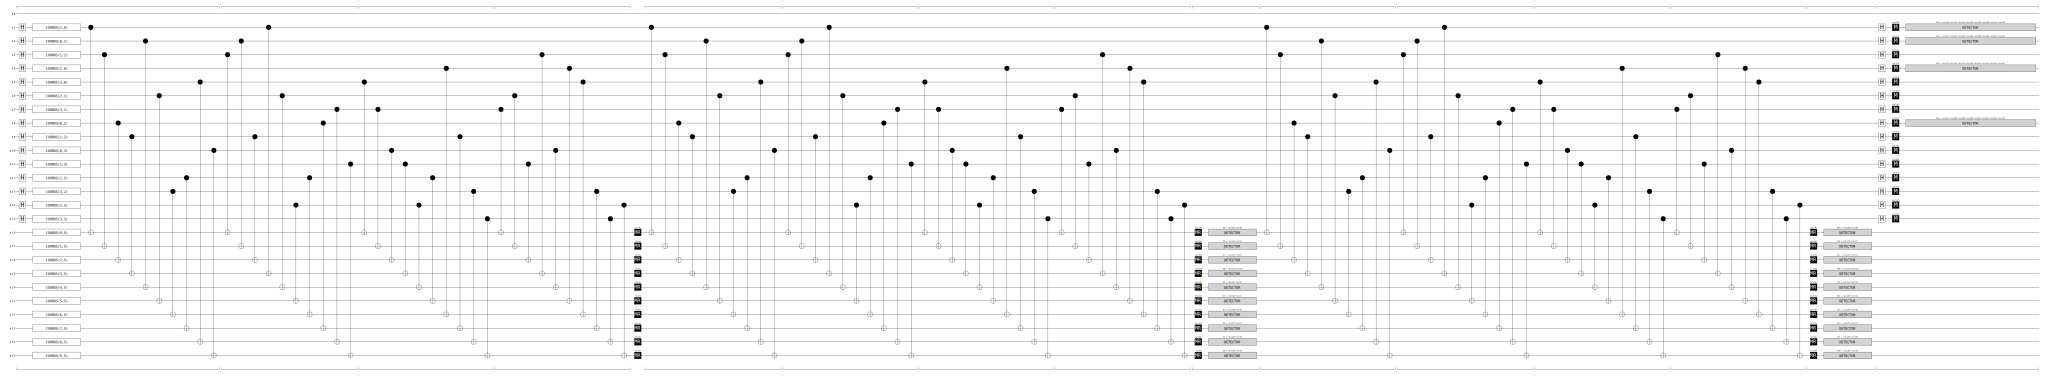

In [ ]:
import stim
import qrm_helper as helper

# initialize 15 qubits labelled from 1 to 15 all to the |0> state and then apply H gates
circuit = stim.Circuit()
circuit.append('H', list(range(1, 16)))

# function to get the i'th bit of an integer n
def get_bit(n, i):
    return (n >> i) & 1

for i in range(1, 16):
    circuit.append_operation("QUBIT_COORDS", [i], [get_bit(i,0) + 2 * get_bit(i,2), get_bit(i,1) + 2 * get_bit(i,3)])
for j in range(16,26):
    circuit.append_operation("QUBIT_COORDS", [j], [j - 16, 5])

for _ in range(3):
    for i in range(4):
        for j in range(10):
            circuit.append('CNOT', [QRM_Z_CHECKS_REDUCED[j][i], 16 + j])
        circuit.append('TICK')
    circuit.append('MR', list(range(16, 26)))
    if _ >= 1:
        for j in range(1,11):
            circuit.append('DETECTOR', [stim.target_rec(-j), stim.target_rec(-j - 10)])
    circuit.append('TICK')

circuit.append('H', list(range(1, 16)))
circuit.append('M', list(range(1, 16)))
# reading out all X stabilizers
for stabilizer in QRM_X_CHECKS:
    circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer])

# helper.add_detectors_between_measurements(circuit, list(range(16, 26)))
    # circuit.append('R', list(range(16, 26)))
circuit.diagram('timeline-svg')
# circuit.diagram('timeslice-svg')

Without any noise, three rounds of measurements always give the same results. All detectors are `False`.

In [42]:
# sample the measurements and detectors
sampler_m = circuit.compile_sampler()
sampler_d = circuit.compile_detector_sampler()
print(sampler_m.sample(3))
print(sampler_d.sample(3))

[[False False  True  True False False  True False  True False False False
   True  True False False  True False  True False False False  True  True
  False False  True False  True False  True False False False  True False
  False False False  True False  True  True False  True]
 [False  True  True  True  True  True False False False  True False  True
   True  True  True  True False False False  True False  True  True  True
   True  True False False False  True  True  True  True False False False
   True  True  True  True False  True False False False]
 [ True  True False False False False False  True  True  True  True  True
  False False False False False  True  True  True  True  True False False
  False False False  True  True  True False  True  True False  True False
   True False False False False False  True  True False]]
[[False False False False False False False False False False False False
  False False False False False False False False False False False False]
 [False False

Now we add noise to the circuit.
For further benchmark, we pack the circuit into a function with adjustable error rates.
We add depolarizing errors.

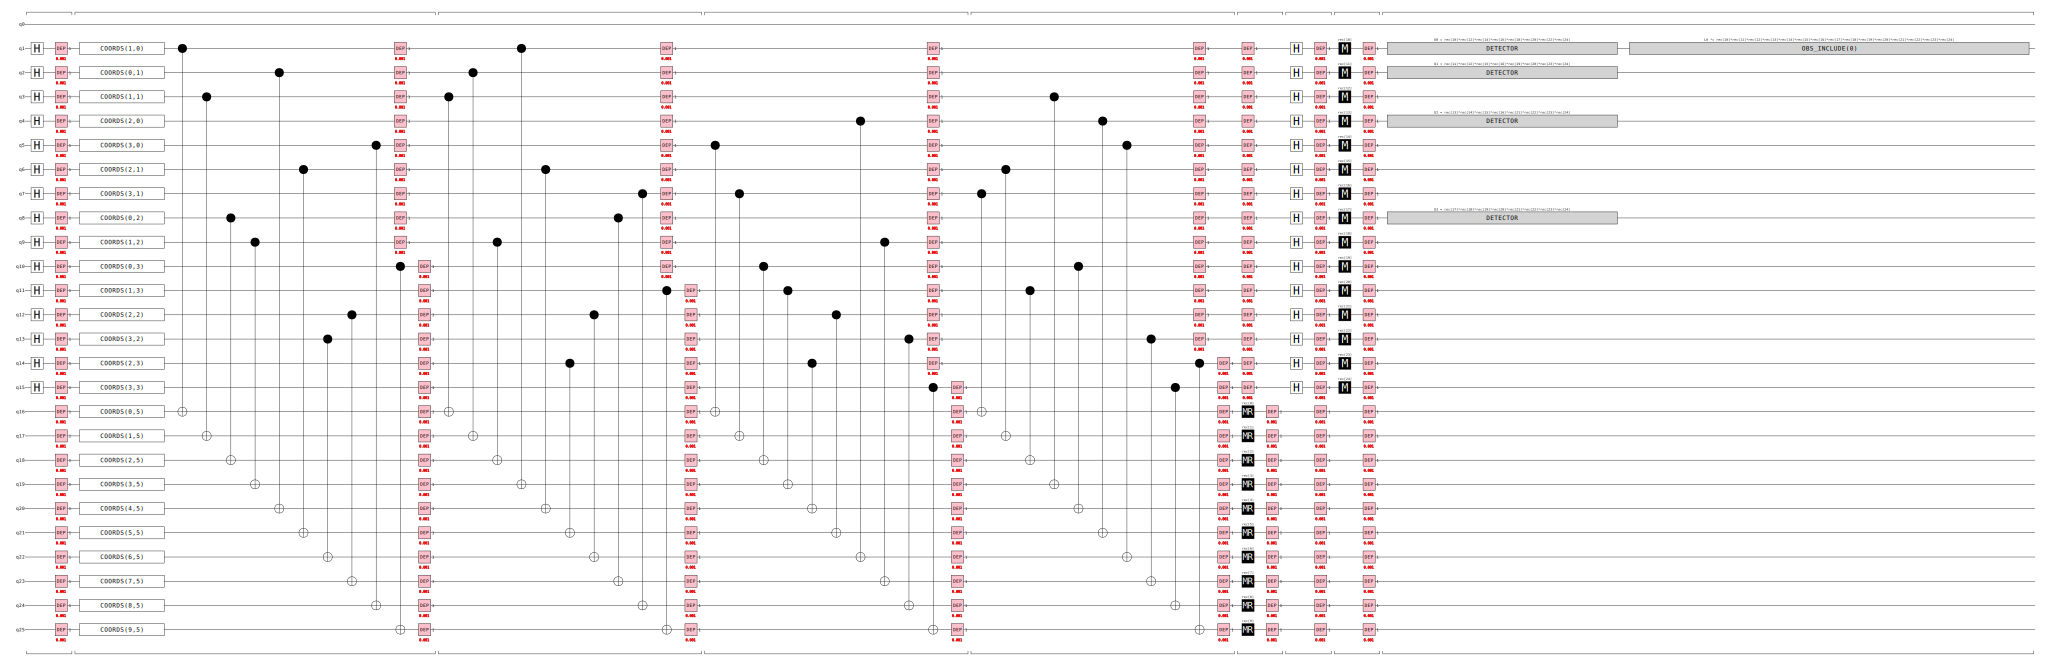

In [174]:
def qrm_circuit(error_rate=0.01, rep_stab=1, rep_meas=1):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,26), [error_rate])
    circuit.append('TICK')

    for i in range(1, 16):
        circuit.append_operation("QUBIT_COORDS", [i], [get_bit(i,0) + 2 * get_bit(i,2), get_bit(i,1) + 2 * get_bit(i,3)])
    for j in range(16,26):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 16, 5])

    for _ in range(rep_stab):
        for i in range(4):
            for j in range(10):
                circuit.append('CNOT', [QRM_Z_CHECKS_REDUCED[j][i], 16 + j])
            circuit.append("DEPOLARIZE1", range(1,26), [error_rate])
            circuit.append('TICK')
        circuit.append('MR', list(range(16, 26)))
        circuit.append("DEPOLARIZE1", range(1,26), [error_rate])
        circuit.append('TICK')
        if _ >= 1:
            for j in range(1,11):
                circuit.append('DETECTOR', [stim.target_rec(-j), stim.target_rec(-j - 10)])

    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,26), [error_rate])
    circuit.append('TICK')

    for _ in range(rep_meas):
        circuit.append('M', list(range(1, 16)))
        circuit.append("DEPOLARIZE1", range(1,26), [error_rate])
        circuit.append('TICK')
    
    for stabilizer in QRM_X_CHECKS:
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer])
    
    # Measuring logical X
    circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)

    return circuit

circuit = qrm_circuit(error_rate=0.001)
circuit.diagram('timeline-svg')

In [151]:
import numpy as np

# sample the measurements and detectors
sampler_m = circuit.compile_sampler()
converter = circuit.compile_m2d_converter()
print(converter.convert(measurements=sampler_m.sample(1), append_observables=True))
# sampler_d = circuit.compile_detector_sampler()

# post-selection depending on the detectors other than -1 and read out the logical X
# N = 100000
# detector_samples = sampler_d.sample(N)
# N_true = (detector_samples.sum(axis=1) == 0).sum()
# N_post = (detector_samples[:, :-1].sum(axis=1) == 0).sum()
# print(f"Post-selection rate: {N_post / N}")
# print(f"Log error rate: {np.log10(1 - N_true / N_post)}")

[[False False False False False]]


Now pack the samplings as a function and vary the error rates to see the scaling.

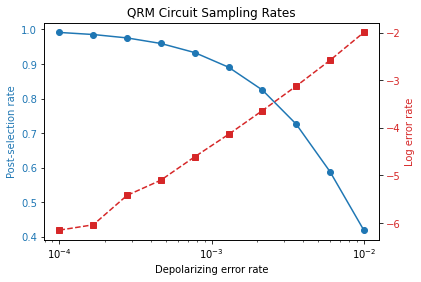

In [203]:
import matplotlib.pyplot as plt

def qrm_sampling(error_rate=0.01, N=100000):
    """
    Samples the QRM circuit with depolarizing noise.
    The error rate can be adjusted.
    Returns the post-selection rate and the error rate.
    """
    circuit = qrm_circuit(error_rate)
    
    sampler = circuit.compile_sampler()
    converter = circuit.compile_m2d_converter()
    detector_samples = converter.convert(measurements=sampler.sample(N), append_observables=True)
    
    N_true = (detector_samples.sum(axis=1) == 0).sum()
    N_post = (detector_samples[:, :-1].sum(axis=1) == 0).sum()
    
    post_selection_rate = N_post / N
    log_error_rate = np.log10(1 - N_true / N_post)
    
    return post_selection_rate, log_error_rate

error_rates = [10**(x) for x in np.linspace(-4, -2, 10)]
post_selection_rates = []
log_error_rates = []
for error_rate in error_rates:
    post_selection_rate, log_error_rate = qrm_sampling(error_rate, N=int(1e7))
    post_selection_rates.append(post_selection_rate)
    log_error_rates.append(log_error_rate)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Depolarizing error rate')
ax1.set_ylabel('Post-selection rate', color=color)
ax1.plot(error_rates, post_selection_rates, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log error rate', color=color)
ax2.plot(error_rates, log_error_rates, 's--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('QRM Circuit Sampling Rates')
plt.show()

Apparently it is a $p^2$ suppression, not $p^3$.
We must modify to add flag gadgets to make it $p^3$.

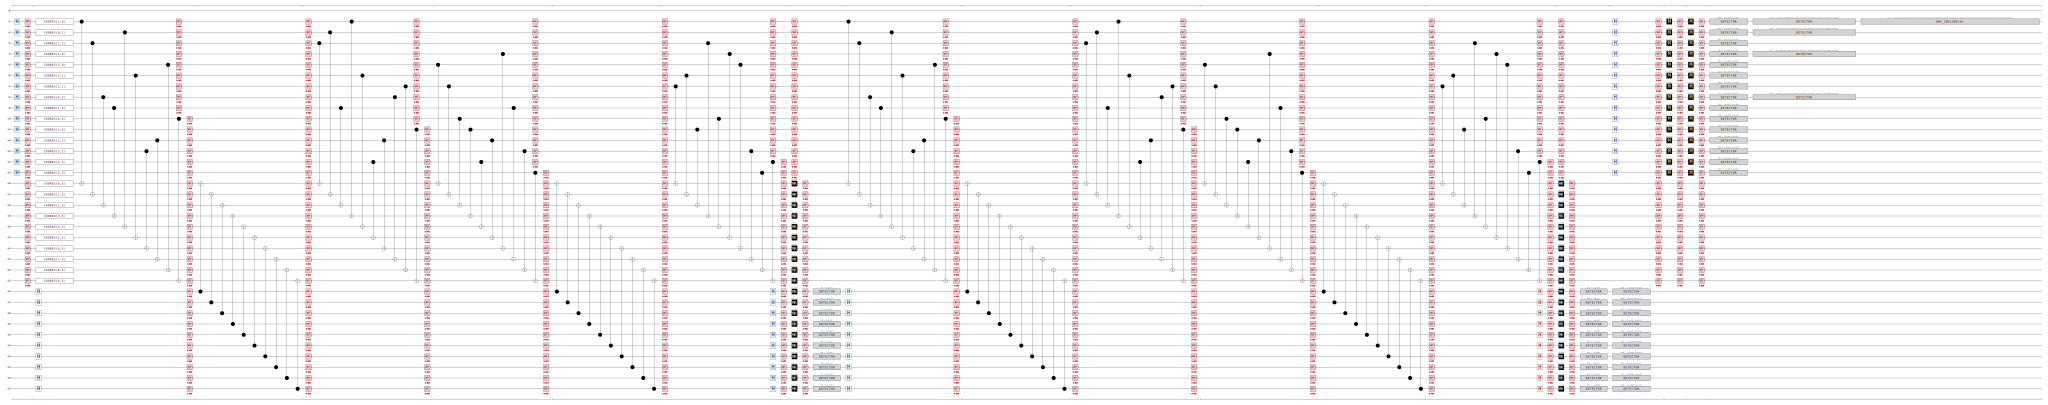

In [204]:
def qrm_circuit_flag(error_rate=0.01, rep_stab=2, rep_meas=2):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,26), [error_rate])
    circuit.append('TICK')

    for i in range(1, 16):
        circuit.append_operation("QUBIT_COORDS", [i], [get_bit(i,0) + 2 * get_bit(i,2), get_bit(i,1) + 2 * get_bit(i,3)])
    for j in range(16,26):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 16, 5])

    for _ in range(rep_stab):
        for i in range(4):
            if i == 0:
                circuit.append('H', list(range(26, 36)))
            if i == 1 or i == 3:
                for j in range(10):
                    circuit.append('CNOT', [26 + j, 16 + j])
                circuit.append('TICK')
                circuit.append("DEPOLARIZE1", range(1,36), [error_rate])
            for j in range(10):
                circuit.append('CNOT', [QRM_Z_CHECKS_REDUCED[j][i], 16 + j])
            if i == 3:
                circuit.append('H', list(range(26, 36)))
            circuit.append("DEPOLARIZE1", range(1,36), [error_rate])
            circuit.append('TICK')
        circuit.append('MR', list(range(16, 36)))
        circuit.append("DEPOLARIZE1", range(1,36), [error_rate])
        for j in range(1, 11):
            circuit.append('DETECTOR', [stim.target_rec(-j)]) # check flags
        circuit.append('TICK')
        if _ >= 1:
            for j in range(1,11):
                circuit.append('DETECTOR', [stim.target_rec(-j), stim.target_rec(-j - 20)]) # check consistency of stabilizers

    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,26), [error_rate])
    circuit.append('TICK')

    for _ in range(rep_meas):
        circuit.append('M', list(range(1, 16)))
        circuit.append("DEPOLARIZE1", range(1,26), [error_rate])
        circuit.append('TICK')
        if _ >= 1:
            for j in range(1,16):
                circuit.append('DETECTOR', [stim.target_rec(-j), stim.target_rec(-j - 15)]) # check consistency of stabilizers
    
    for stabilizer in QRM_X_CHECKS:
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer])
    
    # Measuring logical X
    circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)

    return circuit

circuit = qrm_circuit_flag(error_rate=0.001)
circuit.diagram('timeline-svg')

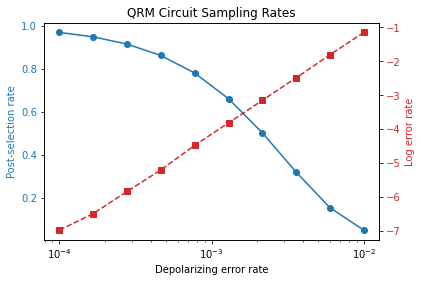

In [205]:
import matplotlib.pyplot as plt

def qrm_sampling(error_rate=0.01, N=100000):
    """
    Samples the QRM circuit with depolarizing noise.
    The error rate can be adjusted.
    Returns the post-selection rate and the error rate.
    """
    circuit = qrm_circuit_flag(error_rate)
    
    sampler = circuit.compile_sampler()
    converter = circuit.compile_m2d_converter()
    detector_samples = converter.convert(measurements=sampler.sample(N), append_observables=True)
    
    N_true = (detector_samples.sum(axis=1) == 0).sum()
    N_post = (detector_samples[:, :-1].sum(axis=1) == 0).sum()
    
    post_selection_rate = N_post / N
    log_error_rate = np.log10(1 - N_true / N_post)
    
    return post_selection_rate, log_error_rate

error_rates = [10**(x) for x in np.linspace(-4, -2, 10)]
post_selection_rates = []
log_error_rates = []
for error_rate in error_rates:
    post_selection_rate, log_error_rate = qrm_sampling(error_rate, N=int(1e7))
    post_selection_rates.append(post_selection_rate)
    log_error_rates.append(log_error_rate)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Depolarizing error rate')
ax1.set_ylabel('Post-selection rate', color=color)
ax1.plot(error_rates, post_selection_rates, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log error rate', color=color)
ax2.plot(error_rates, log_error_rates, 's--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('QRM Circuit Sampling Rates')
plt.show()